In [2]:
import keras
import numpy as np
import pandas as pd
from keras import models, layers
from keras.layers import *
import joblib

Using TensorFlow backend.


In [3]:
from speedups import *

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.utils.class_weight import compute_class_weight
import os

In [5]:
def normalization(X):
    for idx in range(len(X)):
        X[idx] = normalize(X[idx])
    return X

In [6]:
path = "../dataview/"
y_val = joblib.load(path + "yvalnoaug")
y_test = joblib.load(path + "ytest")
y_train = joblib.load(path + "ytrain")
y_val = y_val.reshape(len(y_val), 1)
y_test = y_test.reshape(len(y_test), 1)

e1hot = OneHotEncoder()
e1hot.fit(y_val);
class_weights = compute_class_weight("balanced", e1hot.categories_[0], y_train)

y_train = y_train.reshape(len(y_train), 1)

e1hot = OneHotEncoder()
e1hot.fit(y_train)
y_train = e1hot.transform(y_train)
y_test = e1hot.transform(y_test)
y_val = e1hot.transform(y_val)

["1013", "1018", "1043", "1084", "14", "16"] - test actors

["1060", "1020", "18", "1004", "OAF"] - val actors

In [7]:
path = "../dataview/"
X_val = joblib.load(path + "xvalnoaug")
X_test = joblib.load(path + "xtest")
X_train = joblib.load(path + "xtrain")

X_test = normalization(X_test)
X_val = normalization(X_val)
X_train = normalization(X_train)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

In [8]:
class_weights

array([1.06543357, 0.73093191, 1.13016878, 1.51199548, 1.41382951,
       0.69454168])

In [9]:
input_shape = X_val.shape[1:]
classes=6

In [10]:
input_shape

(80, 76, 1)

In [11]:
class Metrics(Callback):
    def set_model(self, model):
        self.model = model
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requeires validation_data.')
        
        val_predict = np.argmax((np.asarray(self.model.predict(self.validation_data[0]))).round(), axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        self.val_f1s.append(_val_f1)
        print(f" — val_f1: {_val_f1}")
        return

In [12]:
def v2x80C2_0(input_shape, classes):
    model = keras.Sequential([
        Conv2D(16, (7, 7), strides=(2, 2), padding="valid", input_shape=input_shape),
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(axis=-1),
        Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same"),
        BatchNormalization(axis=-1),
        Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same"),
        BatchNormalization(axis=-1),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(axis=-1),
        Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same"),
        BatchNormalization(axis=-1),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(axis=-1),
        Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same"),
        BatchNormalization(axis=-1),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(axis=-1),
        Dropout(0.5),
        Dense(classes, activation="softmax")
    ])
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
    model.summary()
    return model

In [25]:
model = v2x80C2_0(input_shape, classes)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks, class_weight=class_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 37, 35, 16)        800       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 35, 33, 32)        4640      
_________________________________________________________________
batch_normalization_33 (Batc (None, 35, 33, 32)        128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 18, 17, 32)        9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 18, 17, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 9, 9, 32)          128       
__________

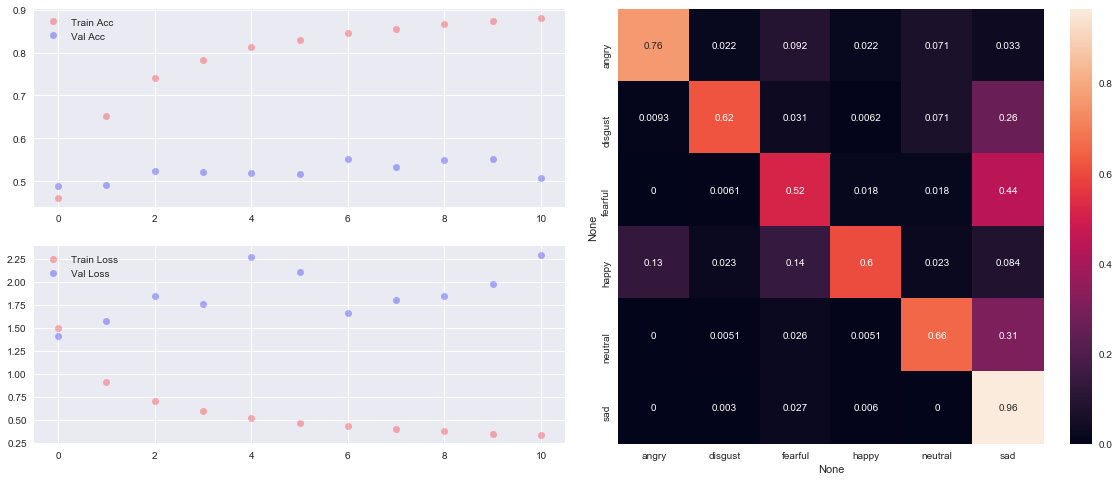

{'micro': 0.7164291072768193, 'macro': 0.7085636890006954, 'weighted': 0.7167362011217496}


In [26]:
draw_full_performance(history, model, X_val, y_val, e1hot.categories_, v2x80C2_0, "./saved/")